In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

In [16]:
def spar(x,f,pos,range):
    y=0*x
    for i in np.arange(0,np.size(x,1)):
        ii=np.random.permutation(np.size(x,0))
        nn=int(max(1,np.fix(np.size(x,0)*f)))
        if pos==1:
            for j in np.arange(0,nn,1):
                y[ii[j],i]=np.random.randint(1,range+1)

        if pos==-1:
            for j in np.arange(0,nn,1):
                y[ii[j],i]=-np.random.randint(1,range+1)

        if pos==0:
            for j in np.arange(0,nn,1):
                y[ii[j],i]=np.random.randint(1,range+1)*((np.random.rand()>0.5)*2-1)
            pin=0
            
            for j in np.arange(np.size(y,0)):
                if y[j,i]<0:
                    pin=1
                    break
            if pin==0:
                for j in np.arange(np.size(y,0)):
                    if y[j,i]>0:
                        y[j,i]=-y[j,i]
                        break
    return y

In [17]:
def GenomeMatrix(NumMet,NumGene,RR):
    NumGeneIn=NumGene-NumMet/4
    S=np.zeros((NumMet,int(NumGeneIn+NumMet/4)))
    range=3
    Num1=int(NumMet/4)

    t=S[0:Num1,int(NumMet/4):int(NumGeneIn/4+NumMet/4)]
    S[0:Num1,int(NumMet/4):int(NumGeneIn/4+NumMet/4)]=spar(t,0.5,-1,3)

    t=S[Num1:2*Num1,int(NumMet/4):int(NumGeneIn/4+NumMet/4)]
    S[Num1:2*Num1,int(NumMet/4):int(NumGeneIn/4+NumMet/4)]=spar(t,0.5,1,3)

    t=S[Num1:2*Num1,int(NumGeneIn/4+NumMet/4):int(NumGeneIn*3/4+NumMet/4)]
    S[Num1:2*Num1,int(NumGeneIn/4+NumMet/4):int(NumGeneIn*3/4+NumMet/4)]=spar(t,0.8,0,3)
    
    t=S[Num1:2*Num1,int(NumGeneIn*3/4+NumMet/4):int(NumGeneIn+NumMet/4)]
    S[Num1:2*Num1,int(NumGeneIn*3/4+NumMet/4):int(NumGeneIn+NumMet/4)]=spar(t,0.5,-1,3)

    t=S[2*Num1:3*Num1,int(NumGeneIn*3/4+NumMet/4):int(NumGeneIn*3/4+NumGene*1/4*RR+NumMet/4)]
    S[2*Num1:3*Num1,int(NumGeneIn*3/4+NumMet/4):int(NumGeneIn*3/4+NumGene*1/4*RR+NumMet/4)]=spar(t,0.5,1,3)

    t=S[3*Num1:4*Num1,int(NumGeneIn*3/4+NumGene*1/4*RR+NumMet/4):int(NumGeneIn+NumMet/4)]
    S[3*Num1:4*Num1,int(NumGeneIn*3/4+NumGene*1/4*RR+NumMet/4):int(NumGeneIn+NumMet/4)]=spar(t,0.5,1,3)

    for i in np.arange(0,int(NumMet/4),1):
        S[i,i]=np.random.randint(1,4)
    return S

In [18]:
def PlasmidMatrix(NumMet,NumGene):
    S=np.zeros((int(NumMet),int(NumGene)))
    range=3
    Num1=int(NumMet/4)

    t=S[Num1:2*Num1,0:int(NumGene)] 
    S[Num1:2*Num1,0:int(NumGene)]=spar(t,0.5,-1,3)

    t=S[Num1*3:Num1*4,0:int(NumGene)]
    S[Num1*3:Num1*4,0:int(NumGene)]=spar(t,0.5,1,3)

    return S

In [19]:
NumMet=80
Type234Genes=np.subtract([200,500,1000],NumMet/4)
Replicates=20
PlasSizes=np.arange(0,200,20)

In [20]:
BURD=np.zeros((len(Type234Genes),Replicates,len(PlasSizes)))
alpha=2
for sdf in np.arange(0,len(Type234Genes),1):
    Type234Gene=Type234Genes[sdf]
    ChroSize=int(Type234Gene+NumMet/4)
    RR=1-np.divide(10,Type234Gene/4)
    for rty in np.arange(0,Replicates,1):
        print(sdf*Replicates+rty)
        ChroNetwork=GenomeMatrix(NumMet,ChroSize,RR)
        NumFluxs=ChroSize+PlasSizes
        coef0=np.random.rand(int(max(NumFluxs)))
        GR=[]
        for i in np.arange(0,len(NumFluxs),1):
            NumFlux=NumFluxs[i]
            coef=np.concatenate((coef0[0:ChroSize],alpha*coef0[ChroSize:NumFlux]),axis=0)
            CellNetwork=np.concatenate((ChroNetwork,PlasmidMatrix(NumMet,NumFlux-ChroSize)),axis=1)
            b0=(0,1)
            Bounds=[b0]
            for j in np.arange(0,NumFlux-1,1):
                Bounds.append(b0)
            CC=np.concatenate((0*coef[0:int(3/4*Type234Gene+NumMet/4)],-coef[int(3/4*Type234Gene+NumMet/4):int(NumFlux)]),axis=0)
            Aeq=CellNetwork[0:int(NumMet/2),0:NumFlux]
            Beq=np.zeros(int(NumMet/2))
            #result = linprog(CC, A_ub=None, b_ub=None, A_eq=Aeq, b_eq=Beq, bounds=Bounds,x0=np.random.rand(NumFlux))
            result = linprog(CC, A_ub=None, b_ub=None, A_eq=Aeq, b_eq=Beq, bounds=Bounds,x0=None)
            tt=result.x
            terp=sum(np.multiply(coef[int(3/4*Type234Gene+NumMet/4):int(3/4*Type234Gene+NumMet/4+RR*Type234Gene/4)],tt[int(3/4*Type234Gene+NumMet/4):int(3/4*Type234Gene+NumMet/4+RR*Type234Gene/4)]))
            GR=np.append(GR,terp)
            BURD[sdf,rty,i]=1-GR[-1]/GR[0]
            


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


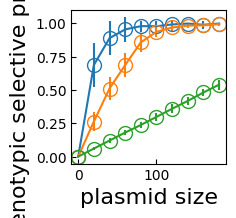

In [21]:
plt.figure(figsize=(2,2))
for i in np.arange(0,len(Type234Genes),1):
    mm=np.mean(BURD[i,0:Replicates,0:len(PlasSizes)],axis=0)
    rr=np.std(BURD[i,0:Replicates,0:len(NumFluxs)],axis=0)
    plt.errorbar(PlasSizes,mm,yerr=rr,marker='o',fillstyle='none',markersize=10)
plt.xlabel('plasmid size',fontsize=16)
plt.ylabel('phenotypic selective pressure',fontsize=16)
plt.tick_params(direction='in')
#plt.legend(labels=['100','500','2000'])
plt.savefig('FigS2d.pdf')
plt.show()
